In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [121]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torch.nn.functional as F
from transformations import Transform

class TripletLoader:
    def __init__(self, dataset: Dataset, transforms: Transform):
        self.dataset = dataset
        self.transforms = transforms
        
    def __call__(self, nsamples: int):
        self.nsamples = nsamples
        self._initialize_loader()
        return self
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current < self.nsamples:
            self.current += 1
            samples, targets = self._triplet()
            transformed_samples = [self.transforms(samples[i], label=targets[i].item()) for i in range(3)]
            return transformed_samples
        raise StopIteration
    
    def _initialize_loader(self):
        self.loader = DataLoader(self.dataset, sampler=RandomSampler(self.dataset), batch_size=self.nsamples)
        self.current = 0
        
    def _triplet(self):
        anchor_idx, positive_idx, negative_idx = 0, float('inf'), float('inf')
        s, t = next(iter(self.loader))
        while torch.tensor(positive_idx).isinf() or torch.tensor(negative_idx).isinf():
            try:
                positive_idx = (t == t[0]).nonzero().flatten()[1].item()
                negative_idx = (t != t[0]).nonzero().flatten()[1].item()
            except IndexError:
                s, t = next(iter(self.loader))
        indices = [anchor_idx, positive_idx, negative_idx]
        return s[indices], t[indices]
        

In [8]:
import transformations
from transformations import PadLabel, ToVector, Scale

loader_transform = transformations.Compose([Scale(), PadLabel(10), ToVector()])
loader = TripletLoader(mnist_data, transforms=loader_transform)
for s in loader(5):
    print(len(s), s[0][0,784:], s[1][0,784:], s[2][0,784:])

3 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]) tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
3 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
3 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]) tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
3 tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
3 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]) tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


In [97]:
from torch import nn
import torchsummary

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.net(x)

In [206]:
from typing import List

class ActivationExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: List[int]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._activations = {layer: torch.empty(0) for layer in layers}
        
        for layer in layers:
            self.model.net[layer].register_forward_hook(self._get_activation(layer))
        
    def _get_activation(self, layer: int):
        def hook(_, __, output):
            self._activations[layer] = torch.cat((self._activations[layer], output.detach()), dim=0)
                
        return hook
    
    def forward(self, x: torch.Tensor):
        _ = self.model(x)
        return self._activations


In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

nepochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loader = DataLoader(mnist_data, batch_size=64, sampler=RandomSampler(mnist_data))
loss_fn = torch.nn.CrossEntropyLoss()

In [119]:
import torch.nn.functional as F

running_loss = 0
for epoch in range(nepochs):
    for i, data in enumerate(loader):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
        if (i+1) % 400 == 0:
            print(f"{epoch=}, batch={i}, {running_loss=:.2f}")
            running_loss = 0
        

epoch=0, batch=399, running_loss=1.95
epoch=0, batch=799, running_loss=0.84
epoch=1, batch=399, running_loss=0.46
epoch=1, batch=799, running_loss=0.30
epoch=2, batch=399, running_loss=0.25
epoch=2, batch=799, running_loss=0.19
epoch=3, batch=399, running_loss=0.28
epoch=3, batch=799, running_loss=0.11
epoch=4, batch=399, running_loss=0.30
epoch=4, batch=799, running_loss=0.21
epoch=5, batch=399, running_loss=0.19
epoch=5, batch=799, running_loss=0.20
epoch=6, batch=399, running_loss=0.24
epoch=6, batch=799, running_loss=0.10
epoch=7, batch=399, running_loss=0.16
epoch=7, batch=799, running_loss=0.06
epoch=8, batch=399, running_loss=0.15
epoch=8, batch=799, running_loss=0.08
epoch=9, batch=399, running_loss=0.17
epoch=9, batch=799, running_loss=0.10
epoch=10, batch=399, running_loss=0.15
epoch=10, batch=799, running_loss=0.02
epoch=11, batch=399, running_loss=0.04
epoch=11, batch=799, running_loss=0.03
epoch=12, batch=399, running_loss=0.06
epoch=12, batch=799, running_loss=0.01
epoch=

In [134]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
correct = 0
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
        prediction = model(input)
        
        if target.item() == prediction.argmax().item():
            correct += 1

print(f"correct={correct/len(test_loader)}")

correct=0.9874


In [207]:
monitored_layers = [6, 7, 9, 11]

activation = ActivationExtractor(model, layers=monitored_layers)
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        targets.append(target.item())
        activations = activation(input)


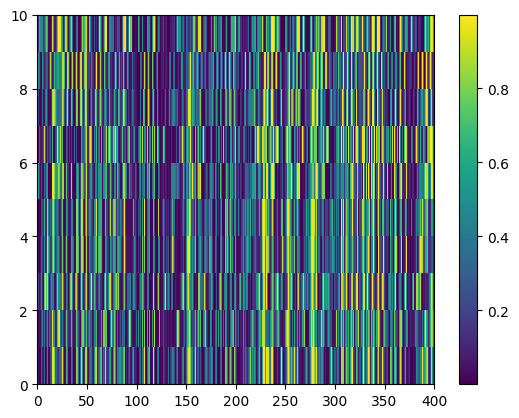

In [212]:
plt.pcolormesh(activations[6][,:])
plt.colorbar()

In [197]:
x = torch.empty(0)
y = torch.rand(1, 5)
torch.cat((x,y), dim=0)

tensor([[0.9268, 0.8276, 0.4418, 0.3110, 0.2306]])